In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #run to disable gpu usage

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Accessing image paths...

In [ ]:
# The dataset is 2GB, thus please use the link below to download it
# https://www.kaggle.com/datasets/gpiosenka/100-bird-species

In [2]:
import pathlib

PATH = "D:/Program Files (x86)/Jupyter Projects/Bird Species Image Recognition/"
train_dir = pathlib.Path(PATH+"train")

In [3]:
image_count = len(list(train_dir.glob('*/*.jpg')))
print(image_count)

58388


In [4]:
valid_dir = pathlib.Path(PATH+"valid")
test_dir = pathlib.Path(PATH+"test")

Creating image datasets...

In [5]:
batch_size = 128
img_height = 224
img_width = 224

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir, seed=123, image_size=(img_height, img_width), batch_size=batch_size)

Found 58388 files belonging to 400 classes.


In [7]:
class_names = train_ds.class_names

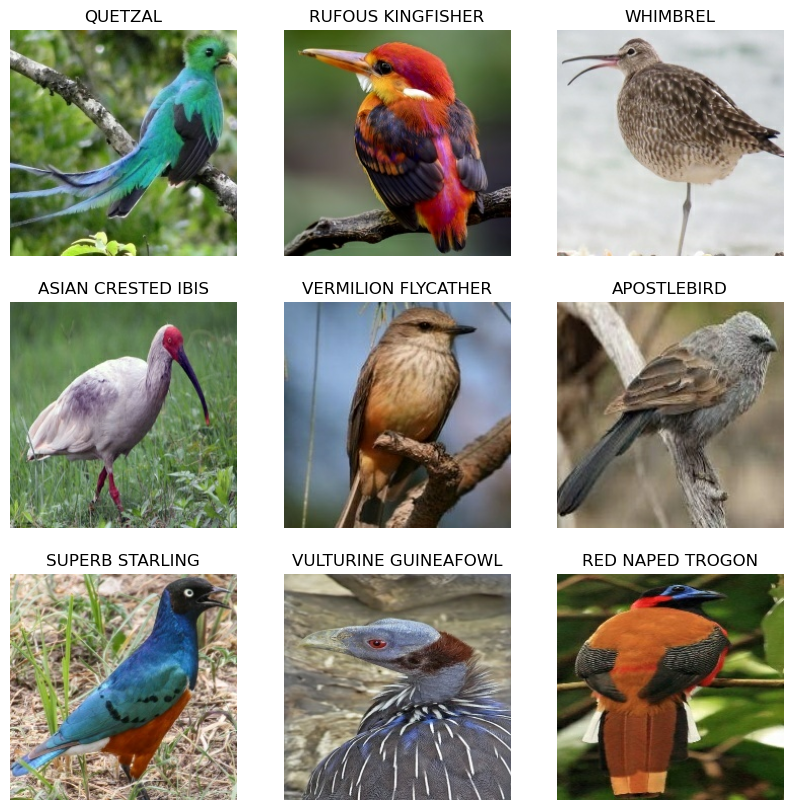

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
valid_ds = tf.keras.utils.image_dataset_from_directory(valid_dir, seed=123, image_size=(img_height, img_width), batch_size=batch_size)
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir, seed=123, image_size=(img_height, img_width), batch_size=batch_size)

Found 2000 files belonging to 400 classes.
Found 2000 files belonging to 400 classes.


Prefetching for performance....

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE) #not enough RAM to cache/shuffle
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

Transfer learning from EfficientNetB4 into model...

In [11]:
tf.keras.backend.clear_session()

In [12]:
num_classes = len(class_names)

inputs = layers.Input(shape=(img_height, img_width, 3))

base_model = tf.keras.applications.efficientnet.EfficientNetB4(include_top=False)
base_model.trainable = False

x = base_model(inputs)

x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)


In [13]:
model = tf.keras.Model(inputs, outputs)

In [14]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam", metrics=["accuracy"])

In [15]:
history = model.fit(train_ds, epochs=10, validation_data=valid_ds)

Epoch 1/10
457/457 [==============================] - 337s 707ms/step - loss: 1.6858 - accuracy: 0.7403 - val_loss: 0.4144 - val_accuracy: 0.9335
Epoch 2/10
457/457 [==============================] - 320s 699ms/step - loss: 0.4754 - accuracy: 0.9096 - val_loss: 0.2345 - val_accuracy: 0.9605
Epoch 3/10
457/457 [==============================] - 305s 667ms/step - loss: 0.3215 - accuracy: 0.9362 - val_loss: 0.1772 - val_accuracy: 0.9655
Epoch 4/10
457/457 [==============================] - 299s 653ms/step - loss: 0.2458 - accuracy: 0.9506 - val_loss: 0.1470 - val_accuracy: 0.9690
Epoch 5/10
457/457 [==============================] - 332s 726ms/step - loss: 0.1981 - accuracy: 0.9611 - val_loss: 0.1287 - val_accuracy: 0.9700
Epoch 6/10
457/457 [==============================] - 366s 800ms/step - loss: 0.1644 - accuracy: 0.9683 - val_loss: 0.1179 - val_accuracy: 0.9725
Epoch 7/10
457/457 [==============================] - 363s 793ms/step - loss: 0.1385 - accuracy: 0.9741 - val_loss: 0.1084 -

Plotting loss and accuracies...

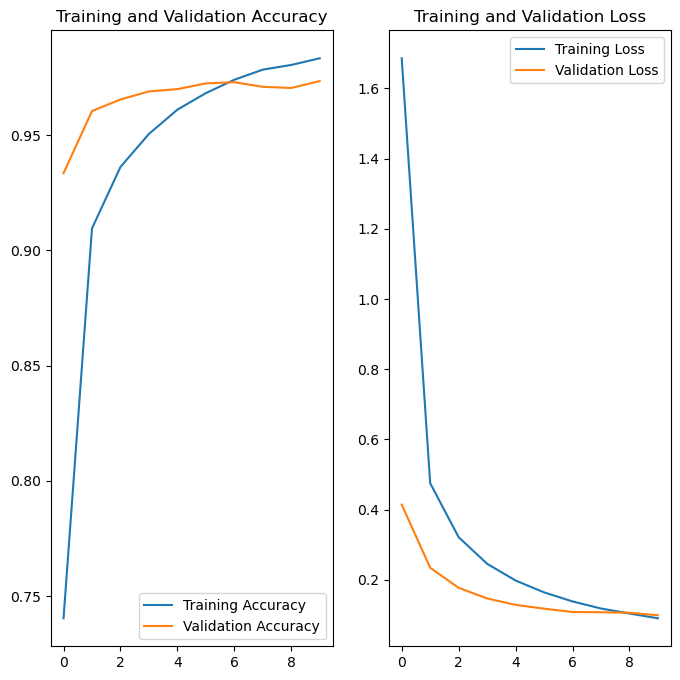

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Evaluating model...

In [17]:
model.evaluate(test_ds, batch_size=batch_size)

16/16 [==============================] - 23s 1s/step - loss: 0.0712 - accuracy: 0.9820


[0.07116762548685074, 0.9819999933242798]

Unfreezing last 10 layers...

In [23]:
for layer in base_model.layers[-10:]:
  layer.trainable = True
  
for layer_number, layer in enumerate(model.layers[1].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block1b_dwconv False
18 block1b_bn False
19 block1b_activation False
20 block1b_se_squeeze False
21 block1b_se_reshape False
22 block1b_se_reduce False
23 block1b_se_expand False
24 block1b_se_excite False
25 block1b_project_conv False
26 block1b_project_bn False
27 block1b_drop False
28 block1b_add False
29 block2a_expand_conv False
30 block2a_expand_bn False
31 block2a_expand_activation False
32 block2a_dwconv_pad False
33 block2a_dwconv False
34 block2a_bn False
35 block2a_activation False
36 block2a_se_squeeze False
37 block2a_se_reshape False
38 block2a_se_reduce False
39 block2a_se_ex

In [26]:
initial_epochs = 10
extra_epochs = initial_epochs + 5

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), metrics=["accuracy"])

In [28]:
updated_history = model.fit(train_ds, epochs=extra_epochs, validation_data=valid_ds, initial_epoch=history.epoch[-1])

Epoch 10/15
457/457 [==============================] - 334s 710ms/step - loss: 0.0812 - accuracy: 0.9829 - val_loss: 0.0899 - val_accuracy: 0.9770
Epoch 11/15
457/457 [==============================] - 321s 702ms/step - loss: 0.0657 - accuracy: 0.9867 - val_loss: 0.0891 - val_accuracy: 0.9745
Epoch 12/15
457/457 [==============================] - 329s 720ms/step - loss: 0.0556 - accuracy: 0.9894 - val_loss: 0.0881 - val_accuracy: 0.9755
Epoch 13/15
457/457 [==============================] - 316s 691ms/step - loss: 0.0479 - accuracy: 0.9907 - val_loss: 0.0833 - val_accuracy: 0.9775
Epoch 14/15
457/457 [==============================] - 318s 696ms/step - loss: 0.0428 - accuracy: 0.9922 - val_loss: 0.0829 - val_accuracy: 0.9755
Epoch 15/15
457/457 [==============================] - 318s 695ms/step - loss: 0.0377 - accuracy: 0.9929 - val_loss: 0.0858 - val_accuracy: 0.9755


In [29]:
model.evaluate(test_ds, batch_size=batch_size)

16/16 [==============================] - 13s 759ms/step - loss: 0.0520 - accuracy: 0.9830


[0.05200718343257904, 0.9829999804496765]

Predictions...

This image most likely belongs to AFRICAN FIREFINCH


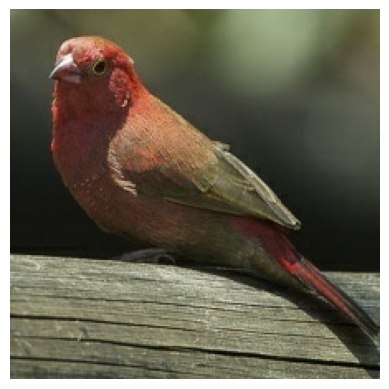

This image most likely belongs to AFRICAN CROWNED CRANE


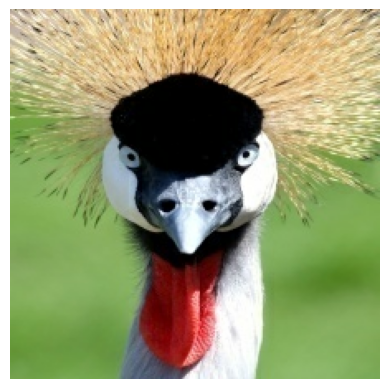

This image most likely belongs to AFRICAN CROWNED CRANE


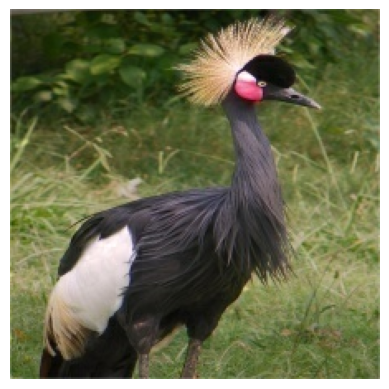

This image most likely belongs to AFRICAN CROWNED CRANE


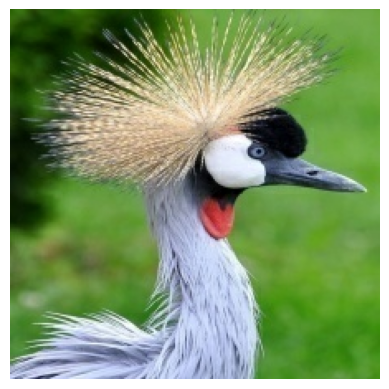

This image most likely belongs to AFRICAN CROWNED CRANE


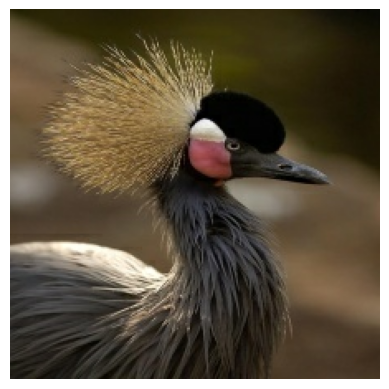

This image most likely belongs to ANTBIRD


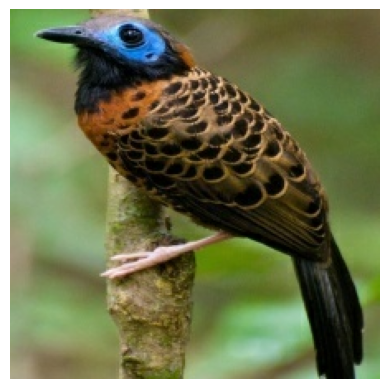

This image most likely belongs to AFRICAN CROWNED CRANE


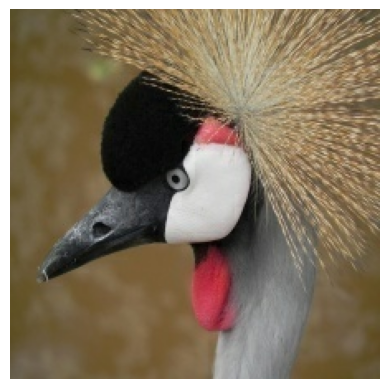

In [30]:
predict_img_dir = PATH+"images to test/"
images = ["1.jpg","2.jpg","3.jpg","4.jpg","5.jpg","7.jpg","14.jpg"]

for image in images:
    
    pred_bird_img = predict_img_dir+image
    img = tf.io.read_file(pred_bird_img)
    img = tf.image.decode_image(img)
    img = tf.image.resize(img, size = [img_height, img_width])
    
    predictions = model.predict(tf.expand_dims(img, 0))
    score = tf.nn.softmax(predictions[0])
    
    plt.show()
    print("This image most likely belongs to {}".format(class_names[np.argmax(score)]))
    plt.imshow(img/255.)
    plt.axis(False)
    

Comparing with EfficientNetB7 model...

In [73]:
tf.keras.backend.clear_session()

In [74]:
inputs = layers.Input(shape=(img_height, img_width, 3))

base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False)
base_model.trainable = False

x = base_model(inputs)

x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(400, activation="softmax")(x)

In [75]:
model3 = tf.keras.Model(inputs, outputs)

In [76]:
model3.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam", metrics=["accuracy"])

In [77]:
history3 = model3.fit(train_ds, epochs=10, validation_data=valid_ds)

Epoch 1/10
457/457 [==============================] - 1243s 3s/step - loss: 1.6051 - accuracy: 0.7248 - val_loss: 0.4197 - val_accuracy: 0.9335
Epoch 2/10
457/457 [==============================] - 1217s 3s/step - loss: 0.4868 - accuracy: 0.9015 - val_loss: 0.2549 - val_accuracy: 0.9475
Epoch 3/10
457/457 [==============================] - 1162s 3s/step - loss: 0.3308 - accuracy: 0.9319 - val_loss: 0.1987 - val_accuracy: 0.9595
Epoch 4/10
457/457 [==============================] - 1339s 3s/step - loss: 0.2489 - accuracy: 0.9492 - val_loss: 0.1730 - val_accuracy: 0.9580
Epoch 5/10
457/457 [==============================] - 1256s 3s/step - loss: 0.1995 - accuracy: 0.9607 - val_loss: 0.1513 - val_accuracy: 0.9625
Epoch 6/10
457/457 [==============================] - 1353s 3s/step - loss: 0.1630 - accuracy: 0.9687 - val_loss: 0.1401 - val_accuracy: 0.9640
Epoch 7/10
457/457 [==============================] - 1189s 3s/step - loss: 0.1363 - accuracy: 0.9741 - val_loss: 0.1316 - val_accuracy:

In [78]:
model3.evaluate(test_ds, batch_size=batch_size)

16/16 [==============================] - 52s 3s/step - loss: 0.0791 - accuracy: 0.9815


[0.07909237593412399, 0.9815000295639038]